In [1]:
# Import libraries

import os
from pathlib import Path
import glob
from raster4ml.preprocessing import stack_bands
from raster4ml.plotting import Map
#from raster4ml.features import VegetationIndices
from raster4ml.extraction import batch_extract_by_points, batch_extract_by_polygons

from pyspatialml import Raster
import pyspatialml.datasets.nc as nc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import tempfile
import rasterio
import cv2

# Machine learning

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


In [3]:
def list_tif_files(dir_path):
    """
    List all .tif files in the specified directory.

    Parameters:
    dir_path (str): Path to the directory containing raster files.

    Returns:
    list: A list of file paths for all .tif files in the directory.
    """
    # List to store .TIF file paths
    tif_files = []

    # Iterate through the directory and add .TIF files to the list
    for filename in os.listdir(dir_path):
        if filename.lower().endswith('.tif'):
            tif_files.append(os.path.join(dir_path, filename))

    return tif_files


In [45]:
# Preprocess raster to have the same extent and coordinate reference systems

def preprocess_raster(input_path, output_path, target_shape):
    with rasterio.open(input_path) as src:
        # Read and convert to float32
        raster_data = src.read(1).astype(np.float32)
        nodata = src.nodatavals[0] if src.nodatavals[0] is not None else 0
        raster_data[raster_data == np.nan] = np.nan

        # Resize image to target_shape
        resized_raster = cv2.resize(raster_data, target_shape, interpolation=cv2.INTER_NEAREST)

        # Write the data to a new file
        with rasterio.open(
            output_path, 'w',
            driver='GTiff',
            height=target_shape[1],
            width=target_shape[0],
            count=1,
            dtype=resized_raster.dtype,
            crs=src.crs,
            transform=src.transform
        ) as dst:
            dst.write(resized_raster, 1)

# Define the target shape (width, height) - replace with your desired dimensions
target_shape = (10505, 10426) #ValueError: could not broadcast input array from shape (10426,10505) into shape (10505,10426)

# Paths to your raster files and the output directory
original_files = list_tif_files("Raster Layers")
 
output_dir = Path(r"Modified Rasters") # Change the path to modify Modified Rasters later

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Preprocess each raster
for file in original_files:
    output_path = os.path.join(output_dir, os.path.basename(file))
    preprocess_raster(file, output_path, target_shape)


In [4]:
# Create a stack band 

stack = Raster(list_tif_files(dir_path = 'Modified Rasters'))

In [49]:
stack.names

dict_keys(['Aspect', 'builtuparea', 'Elevation', 'LST', 'LULCC', 'PopDensity', 'Poverty', 'Precipitation', 'Slope'])

In [8]:
# Store a stack band to a file for further processing

stack.write(file_path= "stacked band.tif", nodata = 0)

Raster Object Containing 9 Layers
    attribute                                             values
0       names  [Aspect, builtuparea, Elevation, LST, LULCC, P...
1       files  [stacked band.tif, stacked band.tif, stacked b...
2        rows                                              10426
3        cols                                              10505
4         res                                       (30.0, 30.0)
5  nodatavals      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [50]:
# Define the map instance
m = Map()
# Add the raster to the map
m.add_raster(image_path='stacked band.tif', bands=[4, 3, 2])
m

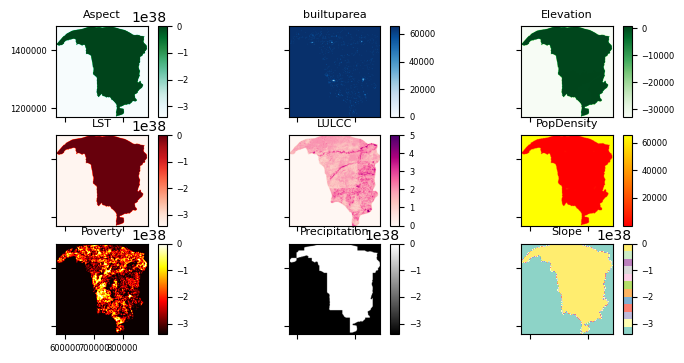

In [5]:
# Visualize each band in the stacked raster file

stack.Aspect.cmap = "BuGn"
stack.builtuparea.cmap = "Blues"
stack.Elevation.cmap = "Greens"
stack.LST.cmap = "Reds"
stack.LULCC.cmap = "RdPu"
stack.PopDensity.cmap = "autumn"
stack.Poverty.cmap = "hot"
stack.Precipitation.cmap = "gist_gray"
stack.Slope.cmap = "Set3"


stack.plot(
    title_fontsize=8,
    label_fontsize=6,
    legend_fontsize=6,
    fig_kwds={"figsize": (8, 4)},
    subplots_kwds={"wspace": 0.5}
)

plt.show()


# a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

In [2]:
# Load your vector data

population_cholera = gpd.read_file("Vector Layers/Population_Cholera.shp")

# strntwk = gpd.read_file("Vector Layers/strntwk.shp")

In [53]:
population_cholera

,ward_name,lga_name,wardPOP,CHLcases,Area,pop_dense,geometry
0,Sasawa/Kabaru,Damaturu,22380,13,586,38,"POLYGON ((12.09087 12.14448, 12.09713 12.12852..."
1,Gwio-Kura,Bade,24021,0,530,45,"POLYGON ((11.11216 12.79503, 11.14683 12.77250..."
2,Mutai,Gujba,18149,105,426,43,"POLYGON ((11.58056 11.31168, 11.58270 11.32787..."
3,Ma'anna,Geidam,17552,0,394,45,"POLYGON ((11.80239 12.69811, 11.78623 12.71379..."
4,Sarkin Hausawa,Bade,6515,0,20,326,"POLYGON ((11.09329 12.84809, 11.09264 12.84752..."
...,...,...,...,...,...,...,...
173,Zajibiriri/Dumbol,Yunusari,16155,0,260,62,"POLYGON ((11.87034 13.10548, 11.87680 13.07531..."
174,Maisandari/Waziri Ibrahim,Damaturu,29762,9,179,166,"POLYGON ((12.06825 11.82453, 12.06236 11.82296..."
175,Buni Yadi,Gujba,42064,107,207,203,"POLYGON ((11.99902 11.33805, 12.01531 11.32656..."
176,Dadingel,Gujba,4905,0,157,31,"POLYGON ((12.20911 11.61220, 12.23234 11.60706..."


In [18]:
population_cholera.describe()

,wardPOP,CHLcases,Area,pop_dense
count,178.000000,178.000000,178.000000,178.000000
mean,18441.561798,13.275281,257.769663,679.140449
std,12626.889097,36.814508,212.198441,2227.507725
min,2580.000000,0.000000,2.000000,12.000000
25%,10834.500000,0.000000,91.000000,42.250000
50%,15843.500000,0.000000,201.500000,71.000000
75%,22114.000000,8.000000,369.250000,147.500000
max,109728.000000,303.000000,1156.000000,15012.000000


In [8]:
pop_cho = population_cholera.iloc[:, [0, 1, 3, 6]]

# Add an ID column before 'ward_name'

pop_cho.insert(0, 'ID', range(1, len(population_cholera) + 1))

pop_cho = pop_cho.to_crs(stack.crs)

pop_cho.head()

,ID,ward_name,lga_name,CHLcases,geometry
0,1,Sasawa/Kabaru,Damaturu,13,"POLYGON ((836438.300 1344440.935, 837140.938 1..."
1,2,Gwio-Kura,Bade,0,"POLYGON ((729279.369 1415405.533, 733065.122 1..."
2,3,Mutai,Gujba,105,"POLYGON ((781698.140 1251687.471, 781916.630 1..."
3,4,Ma'anna,Geidam,0,"POLYGON ((804368.929 1405388.768, 802593.194 1..."
4,5,Sarkin Hausawa,Bade,0,"POLYGON ((727182.477 1421260.280, 727112.033 1..."


In [72]:
pop_cho.to_file('Cholera-data-reshaped/cholera_modified.shp')

**The remaining work was done in R because the extraction of raster was not working in Python. I have tried many modules such as raster4ml.extraction and pyspatialml.extract_vector**

To follow along, you will need to first [install R](https://cran.r-project.org/bin/windows/base/R-4.3.2-win.exe) and [RStudio](https://download1.rstudio.org/electron/windows/RStudio-2023.12.1-402.exe) if you have done that before. Then open the `Cholera Project.Rproj` R programming file. This will open the **Cholera Project** RStudio project. Then open `R-Project-Script.R` which contains the R codes.

In [2]:
# Load your vector data

data_analysis = gpd.read_file("data-analysis/analysis_data.shp")

data_analysis.head()

,ID,Aspect,builtpr,Elevatn,LST,LULCC,PpDnsty,Poverty,Prcpttn,Slope,ward_nm,lga_nam,CHLcass,geometry
0,46.0,212.471191,65535.0,346.0,39.352005,2.0,131.0,-3.402823e+22,8.0,6.201054,Afunori,Nguru,0.0,"POLYGON ((651047.608 1447587.245, 648788.949 1..."
1,46.0,348.690063,65535.0,343.0,38.335266,2.0,131.0,-3.402823e+22,8.0,3.646971,Afunori,Nguru,0.0,"POLYGON ((651047.608 1447587.245, 648788.949 1..."
2,46.0,98.130104,65535.0,338.0,42.072643,2.0,131.0,9.327827e+01,8.0,1.687605,Afunori,Nguru,0.0,"POLYGON ((651047.608 1447587.245, 648788.949 1..."
3,46.0,206.565048,65535.0,342.0,40.350941,2.0,131.0,-3.402823e+22,8.0,2.134300,Afunori,Nguru,0.0,"POLYGON ((651047.608 1447587.245, 648788.949 1..."
4,46.0,30.963757,65535.0,344.0,39.659851,2.0,131.0,9.575846e+01,8.0,2.781886,Afunori,Nguru,0.0,"POLYGON ((651047.608 1447587.245, 648788.949 1..."


# Preprocessing Steps:

- Handle Geospatial Data: Convert the geometry column to features that can be used by regression models (e.g., area, perimeter, centroid coordinates).
- Scaling Numerical Features: Scale the numerical features to ensure no variable dominates because of its scale.
- Handle Missing Values: Impute or remove missing values.
- Feature Engineering: Create new features that might help improve model performance.
- Data Splitting: Split the data into training and test sets.

# Models to Train:

- Random Forest Regression: This ensemble learning method is good for handling complex datasets with a mix of variable types. It can capture non-linear relationships between features and the target variable. Random Forest is also less prone to overfitting and can handle missing values, which might be beneficial for complex geospatial data.

- Gradient Boosting Machines (GBM): Models like XGBoost, LightGBM, or CatBoost are powerful for classification tasks and can deal with various types of data. They sequentially build weak learners to form a strong predictive model and can handle the intricacies in the data, improving accuracy significantly.

- Support Vector Machines (SVM): SVM can be particularly useful for binary classification problems (like predicting the presence or absence of cholera cases). It works well with high-dimensional data and can model complex relationships by using different kernel functions.

- Deep Learning Models (Convolutional Neural Networks - CNNs): For spatial data, especially when working with raster data (like LST or elevation maps), CNNs can extract spatial hierarchies and patterns effectively. These models can be adapted to work with both spatial and non-spatial features, offering a comprehensive analysis of factors influencing cholera outbreaks.

- Geographically Weighted Regression (GWR): This is more of a statistical approach than machine learning, but GWR is beneficial for modeling spatial data since it allows the relationships between the predictors and the outcome to vary across space. This model can help understand how the influence of different factors on cholera cases changes across different locations.


## Data Preprocessing

In [3]:
# Feature engineering from geometry - Example: Calculate the area of each polygon

data_analysis['Area'] = data_analysis['geometry'].area

# Calculate centroids since geometries are polygons and extract coordinates

data_analysis['centroid'] = data_analysis.centroid
data_analysis['lon'] = data_analysis['centroid'].x
data_analysis['lat'] = data_analysis['centroid'].y


In [4]:
# Extracting numerical features and target variable

X = data_analysis.drop(['ID', 'ward_nm', 'lga_nam', 'CHLcass', 'geometry', 'centroid', 'lon', 'lat', 'Area'], axis=1)
y = data_analysis['CHLcass']

# Splitting the dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Random Forest

In [7]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)
print('Random Forest RMSE:', np.sqrt(mean_squared_error(y_test, rf_pred)))


Random Forest RMSE: 20.044794436453177


## Gradient Boosting Machines (GBM): xgboost

In [6]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=5, alpha=10, n_estimators=10, random_state=42)
xg_reg.fit(X_train_scaled, y_train)
xgb_pred = xg_reg.predict(X_test_scaled)
print('XGBoost RMSE:', np.sqrt(mean_squared_error(y_test, xgb_pred)))


XGBoost RMSE: 40.09203633796392


## SVM

In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel='rbf')
svm_reg.fit(X_train_scaled, y_train)
svm_pred = svm_reg.predict(X_test_scaled)
print('SVM RMSE:', np.sqrt(mean_squared_error(y_test, svm_pred)))

## Geographically Weighted Regression (GWR)

In [7]:
# Prepare your independent variables (X) and dependent variable (y)

# Include relevant features and exclude 'ID', 'CHLcass', 'geometry', 'centroid', etc.

X = data_analysis[['Aspect', 'builtpr', 'Elevatn', 'LST', 'LULCC', 'PpDnsty', 'Poverty', 'Prcpttn', 'Slope', 'Area']] # Add or remove columns based on your feature engineering
y = data_analysis['CHLcass'].values.reshape((-1, 1))

# Convert X to include an intercept
X = np.hstack((np.ones(y.shape), X))

# Extract coordinates for GWR
coords = data_analysis[['lon', 'lat']].values


In [10]:
# Select bandwidth

# Use a subset of the data for bandwidth selection to speed up the process

sample_indices = np.random.choice(np.arange(len(y)), size=int(len(y) * 0.02), replace=False)

coords_sample = coords[sample_indices]

y_sample = y[sample_indices]

X_sample = X[sample_indices]

In [16]:
#bw = Sel_BW(coords_sample, y_sample, X_sample).search()

In [30]:
# Initialize and fit GWR

model = GWR(coords, y_sample, X_sample, bw=15).fit()


ValueError: operands could not be broadcast together with shapes (20353,11) (1017686,1) 

## Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM)

In [16]:
# Data needs to be in a sequence format


features = data_analysis[['Aspect', 'builtpr', 'Elevatn', 'LST', 'LULCC', 'PpDnsty', 'Poverty', 'Prcpttn', 'Slope', 'Area']].values
target = data_analysis['CHLcass'].values



In [34]:
# Function to create sequences
def create_sequences(features, target, sequence_length):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i+sequence_length])
        y.append(target[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 5  # Number of time steps to look back
X, y = create_sequences(features, target, sequence_length)

# Splitting the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [35]:
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
y_train = np.nan_to_num(y_train, nan=0.0, posinf=0.0, neginf=0.0)

X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)
y_test = np.nan_to_num(y_test, nan=0.0, posinf=0.0, neginf=0.0)

In [38]:
# Define the LSTM model

model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, X_train.shape[2]), kernel_regularizer=l2(0.01)),
    Dense(1, kernel_regularizer=l2(0.01))
])

In [39]:
# Compile the model with the Adam optimizer and a learning rate of 0.001

model.compile(optimizer=Adam(learning_rate=0.001, clipvalue=0.5), loss='mean_squared_error')

In [40]:
# Train the model

history = model.fit(X_train, y_train, epochs=20, validation_split=0.2)


Epoch 1/20
20354/20354 [==============================] - 99s 5ms/step - loss: nan - val_loss: nan
Epoch 2/20
20354/20354 [==============================] - 93s 5ms/step - loss: nan - val_loss: nan
Epoch 3/20
20354/20354 [==============================] - 95s 5ms/step - loss: nan - val_loss: nan
Epoch 4/20
20354/20354 [==============================] - 99s 5ms/step - loss: nan - val_loss: nan
Epoch 5/20
20354/20354 [==============================] - 93s 5ms/step - loss: nan - val_loss: nan
Epoch 6/20
20354/20354 [==============================] - 91s 4ms/step - loss: nan - val_loss: nan
Epoch 7/20
20354/20354 [==============================] - 93s 5ms/step - loss: nan - val_loss: nan
Epoch 8/20
20354/20354 [==============================] - 91s 4ms/step - loss: nan - val_loss: nan
Epoch 9/20
20354/20354 [==============================] - 88s 4ms/step - loss: nan - val_loss: nan
Epoch 10/20
20354/20354 [==============================] - 89s 4ms/step - loss: nan - val_loss: nan
Epoch 11/

In [ ]:
# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print('Test MSE:', test_loss)


In [8]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression; predicts cholera cases
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


In [ ]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2)


Epoch 1/100

20354/20354 [==============================] - 64s 3ms/step - loss: nan - val_loss: nan
Epoch 2/100
20354/20354 [==============================] - 61s 3ms/step - loss: nan - val_loss: nan
Epoch 3/100
20354/20354 [==============================] - 63s 3ms/step - loss: nan - val_loss: nan
Epoch 4/100
20354/20354 [==============================] - 65s 3ms/step - loss: nan - val_loss: nan
Epoch 5/100
20354/20354 [==============================] - 66s 3ms/step - loss: nan - val_loss: nan
Epoch 6/100
20354/20354 [==============================] - 66s 3ms/step - loss: nan - val_loss: nan
Epoch 7/100
20354/20354 [==============================] - 68s 3ms/step - loss: nan - val_loss: nan
Epoch 8/100
20354/20354 [==============================] - 73s 4ms/step - loss: nan - val_loss: nan
Epoch 9/100
20354/20354 [==============================] - 71s 3ms/step - loss: nan - val_loss: nan
Epoch 10/100
20354/20354 [==============================] - 65s 3ms/step - loss: nan - val_loss: na